# Main

## Import

In [42]:
import duckdb
import pandas as pd
import seaborn as sns
import numpy as np
from datetime import datetime
from scipy.signal import find_peaks

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from matplotlib.patches import Patch
from matplotlib.patches import Circle, Rectangle

from matplotlib.backends.backend_pdf import PdfPages
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, Table, PageBreak
from reportlab.lib import colors
from reportlab.lib.styles import ParagraphStyle
from reportlab.lib.units import inch
from reportlab.platypus import TableStyle
from reportlab.lib import styles
from reportlab.lib.styles import getSampleStyleSheet
import os


# Connexion
con = duckdb.connect("football.duckdb")

# Sécurité mémoire
con.execute("PRAGMA threads=4;")
con.execute("PRAGMA memory_limit='8GB';")

print("DuckDB ready")

DuckDB ready


## Clean
### Jointure Nom des joeurs et sensor_id en fonction des sessions_date
Etant donnée que certain joueurs échanger de sensor, nous devons assigner tous les jouerus au bon sensor à la bonne date

In [43]:
# Create a SQL view from the tracking table with relevant columns
con.execute("""
CREATE OR REPLACE VIEW tracking_v1 AS
SELECT
    session_type,
    session_date,
    player_id AS sensor_id,  -- Rename player_id to sensor_id to match sensor mapping
    time_utc,
    x_pos,
    y_pos,
    latitude,
    longitude,
    speed_kmh
FROM tracking
""")

# Load CSV mapping file and clean/format data
df_map = (
    pd.read_csv("data/summary.csv", sep=",")
    .assign(
        session_date=lambda x: pd.to_datetime(
            x["date"],
            format="%Y-%m-%d %H:%M:%S",
            errors="raise"   # Convert to date and raise error if format is incorrect
        ).dt.date
    )
    .rename(columns={
        "Sensor": "sensor_id",  # Standardize column names
        "last_name": "player_id"
    })
    [["session_date", "sensor_id", "player_id"]]  # Keep only relevant columns
    .drop_duplicates()  # Remove duplicate rows
)

# Register the DataFrame as a temporary table for SQL queries
con.register("sensor_player_map", df_map)

# Create a SQL view from the temporary mapping table
con.execute("""
CREATE OR REPLACE VIEW mapping_v AS
SELECT * FROM sensor_player_map
""")

# Join tracking data with sensor->player mapping
con.execute("""
CREATE OR REPLACE VIEW tracking_v2 AS
SELECT
    t.*,
    m.player_id
FROM tracking_v1 t
LEFT JOIN mapping_v m
ON t.sensor_id = m.sensor_id
AND t.session_date = m.session_date
""")

# Identify sensors that could not be mapped to a player
unmapped = con.execute("""
SELECT
    session_date,
    sensor_id,
    COUNT(*) AS n_rows
FROM tracking_v2
WHERE player_id IS NULL
GROUP BY session_date, sensor_id
ORDER BY n_rows DESC
""").df()

# Create the final table containing only mapped rows
con.execute("""
CREATE OR REPLACE TABLE tracking_player AS
SELECT *
FROM tracking_v2
WHERE player_id IS NOT NULL;
""")

# Summary statistics: total rows, unique players, sessions, and sensors
summary = con.execute("""
SELECT
    COUNT(*) AS n_rows,
    COUNT(DISTINCT player_id) AS n_players,
    COUNT(DISTINCT session_date) AS n_sessions,
    COUNT(DISTINCT sensor_id) AS n_sensors
FROM tracking_player
""").df()

# Summary by session type: number of unique sessions per type
summary2 = con.execute("""
SELECT
    session_type,
    COUNT(DISTINCT session_date) AS n_sessions
FROM tracking_player
GROUP BY session_type;
""").df()

# Print the summaries
print(summary)
print(summary2)


      n_rows  n_players  n_sessions  n_sensors
0  166541023         42         258         29
  session_type  n_sessions
0     practice         187
1         game          74


## Pseudonomisation

In [44]:
# Extract all unique players from the final tracking table
player = con.execute("""
SELECT DISTINCT player_id
FROM tracking_player
""").df()

# Assign a sequential number to each player
player['player_number'] = np.arange(1, len(player) + 1)

# Save the mapping to a CSV file
player.to_csv("data/player_numbering.txt", index=False, header=True)

# Register the numbered players as a temporary table in DuckDB
con.register("player_numbered", player)

# Retrieve all column names from tracking_player except 'player_id'
cols = con.execute("PRAGMA table_info(tracking_player)").df()
cols = [c for c in cols['name'] if c != 'player_id']
cols_sql = ", ".join([f"tp.{c}" for c in cols])  # Prepare columns for SQL

# Create a table with pseudo numbers instead of player_id
con.execute(f"""
CREATE OR REPLACE TABLE tracking_pseudo AS
SELECT
    {cols_sql},
    pn.player_number AS player_pseudo  -- Use player_number as pseudo
FROM tracking_player tp
JOIN player_numbered pn ON tp.player_id = pn.player_id
""")

# Retrieve all distinct session dates for player pseudo 20 in year 2020
df_sessions = con.execute("""
SELECT DISTINCT session_date
FROM tracking_pseudo
WHERE player_pseudo = 20
  AND YEAR(session_date) = 2020
ORDER BY session_date
""").df()



## Vitesse abérante
Nettoyage des vitesse abérantes par 2 algorythme position par z-score et vitesse par IQR

In [45]:
# ============================================================================ 
# STEP 1: DETECT OUTLIERS BASED ON EXCESSIVE SPEED
# ============================================================================

con.execute("""
CREATE OR REPLACE VIEW extreme_vitesse AS
SELECT
    player_pseudo,
    session_type,
    session_date,
    sensor_id,
    MAX(speed_kmh) AS max_speed
FROM tracking_pseudo
GROUP BY player_pseudo, session_type, session_date, sensor_id
HAVING MAX(speed_kmh) > 35;  -- Keep only sessions where max speed exceeds 35 km/h
""").df()


# ============================================================================ 
# STEP 2: IDENTIFY EXACT POINTS WITH OUTLIERS
# ============================================================================

def detect_outlier_sequences_position_z(df, z_threshold=3):
    """
    Detect positional outliers based on z-score of x and y coordinates.
    Marks start and end of continuous outlier sequences.
    """
    df = df.sort_values('time_utc').reset_index(drop=True)
    
    mean_x = df['x_pos'].mean()
    std_x = df['x_pos'].std()
    mean_y = df['y_pos'].mean()
    std_y = df['y_pos'].std()
    
    df['z_x'] = (df['x_pos'] - mean_x) / std_x
    df['z_y'] = (df['y_pos'] - mean_y) / std_y
    df['z_dist'] = np.sqrt(df['z_x']**2 + df['z_y']**2)
    
    df['is_outlier_position'] = df['z_dist'] > z_threshold
    
    # Initialize start/end flags for sequences
    df['outlier_start_position'] = False
    df['outlier_end_position'] = False
    
    # Mark start and end of consecutive outlier sequences
    in_sequence = False
    for i in range(len(df)):
        if df.loc[i, 'is_outlier_position'] and not in_sequence:
            df.loc[i, 'outlier_start_position'] = True
            in_sequence = True
        elif not df.loc[i, 'is_outlier_position'] and in_sequence:
            df.loc[i-1, 'outlier_end_position'] = True
            in_sequence = False
    if in_sequence:
        df.loc[len(df)-1, 'outlier_end_position'] = True

    return df


def detect_local_outliers_speed_iqr_global_iqr(df, speed_trigger=35, window_sec=5, multiplier=1.5):
    """
    Detect speed outliers using IQR method within a window around peaks exceeding speed_trigger.
    Marks start and end of continuous speed outlier sequences.
    """
    df = df.sort_values('time_utc').reset_index(drop=True)
    df['is_outlier_speed'] = False

    # Compute global IQR thresholds
    Q1_global = df['speed_kmh'].quantile(0.25)
    Q3_global = df['speed_kmh'].quantile(0.75)
    IQR_global = Q3_global - Q1_global
    lower_global = Q1_global - multiplier * IQR_global
    upper_global = Q3_global + multiplier * IQR_global

    # Identify high-speed peaks
    peaks = df[df['speed_kmh'] > speed_trigger]['time_utc']

    # Flag outliers around each peak in a time window
    for peak_time in peaks:
        start_time = peak_time - pd.Timedelta(seconds=window_sec)
        end_time = peak_time + pd.Timedelta(seconds=window_sec)

        mask = (
            (df['time_utc'] >= start_time) &
            (df['time_utc'] <= end_time) &
            ((df['speed_kmh'] < lower_global) | (df['speed_kmh'] > upper_global))
        )

        df.loc[mask, 'is_outlier_speed'] = True

    # Initialize start/end flags for sequences
    df['outlier_start_speed'] = False
    df['outlier_end_speed'] = False
    
    # Mark start and end of consecutive speed outlier sequences
    in_sequence = False
    for i in range(len(df)):
        if df.loc[i, 'is_outlier_speed'] and not in_sequence:
            df.loc[i, 'outlier_start_speed'] = True
            in_sequence = True
        elif not df.loc[i, 'is_outlier_speed'] and in_sequence:
            df.loc[i-1, 'outlier_end_speed'] = True
            in_sequence = False
    if in_sequence:
        df.loc[len(df)-1, 'outlier_end_speed'] = True

    return df


# ============================================================================ 
# RETRIEVE SESSIONS TO ANALYZE
# ============================================================================

sessions_to_analyze = con.execute("""
SELECT DISTINCT 
    player_pseudo,
    session_type,
    session_date,
    sensor_id
FROM extreme_vitesse
ORDER BY player_pseudo, session_type, session_date, sensor_id
""").df()

print(f"Sessions to analyze: {len(sessions_to_analyze)}")


# ============================================================================ 
# CREATE TABLE TO STORE OUTLIER POINTS
# ============================================================================

con.execute("""
CREATE OR REPLACE TABLE outliers_points (
    player_pseudo BIGINT,
    session_type VARCHAR,
    session_date DATE,
    sensor_id INTEGER,
    time_utc TIMESTAMP,
    x_pos DOUBLE,
    y_pos DOUBLE,
    speed_kmh DOUBLE,
    is_outlier_combined BOOLEAN,
    outlier_start_combined BOOLEAN,
    outlier_end_combined BOOLEAN
)
""")


# ============================================================================ 
# ANALYZE EACH SESSION
# ============================================================================

for idx, session in sessions_to_analyze.iterrows():
    player = session['player_pseudo']
    session_type = session['session_type']
    date = session['session_date']
    sensor = session['sensor_id']
    
    print(f"[{idx+1}/{len(sessions_to_analyze)}] {player} | {session_type} | {date} | {sensor}")
    
    # Retrieve session data
    df_session = con.execute(f"""
    SELECT 
        player_pseudo,
        session_type,
        session_date,
        sensor_id,
        time_utc,
        x_pos,
        y_pos,
        speed_kmh
    FROM tracking_pseudo
    WHERE player_pseudo = '{player}'
      AND session_type = '{session_type}'
      AND session_date = '{date}'
      AND sensor_id = '{sensor}'
    ORDER BY time_utc
    """).df()
    
    # Detect position and speed outliers
    df_with_outliers = detect_outlier_sequences_position_z(df_session)
    df_with_outliers = detect_local_outliers_speed_iqr_global_iqr(df_with_outliers)

    # Combine outlier flags
    df_with_outliers['is_outlier_combined'] = (
        df_with_outliers['is_outlier_position'] |
        df_with_outliers['is_outlier_speed']
    )

    df_with_outliers['outlier_start_combined'] = (
        df_with_outliers['outlier_start_position'] |
        df_with_outliers['outlier_start_speed']
    )

    df_with_outliers['outlier_end_combined'] = (
        df_with_outliers['outlier_end_position'] |
        df_with_outliers['outlier_end_speed']
    )

    # Keep only relevant columns for storage
    df_to_save = df_with_outliers[[
        'player_pseudo',
        'session_type',
        'session_date',
        'sensor_id',
        'time_utc',
        'x_pos',
        'y_pos',
        'speed_kmh',
        'is_outlier_combined',
        'outlier_start_combined',
        'outlier_end_combined'
    ]]
    
    # Insert session results into outliers_points table
    con.register('temp_outliers', df_to_save)
    con.execute("INSERT INTO outliers_points SELECT * FROM temp_outliers")
    con.unregister('temp_outliers')

print("Outlier detection completed")


# ============================================================================ 
# STEP 3: IDENTIFY CONTINUOUS OUTLIER SEQUENCES
# ============================================================================

con.execute("""
CREATE OR REPLACE TABLE outlier_sequences AS
WITH numbered_outliers AS (
    SELECT 
        *,
        ROW_NUMBER() OVER (
            PARTITION BY player_pseudo, session_type, session_date, sensor_id
            ORDER BY time_utc
        ) as row_num,
        ROW_NUMBER() OVER (
            PARTITION BY player_pseudo, session_type, session_date, sensor_id
            ORDER BY time_utc
        ) - ROW_NUMBER() OVER (
            PARTITION BY player_pseudo, session_type, session_date, sensor_id, is_outlier_combined
            ORDER BY time_utc
        ) as sequence_group
    FROM outliers_points
),
sequences AS (
    SELECT 
        player_pseudo,
        session_type,
        session_date,
        sensor_id,
        is_outlier_combined,
        sequence_group,
        MIN(time_utc) as seq_start_time,
        MAX(time_utc) as seq_end_time,
        COUNT(*) as seq_length,
        MIN(row_num) as start_row,
        MAX(row_num) as end_row
    FROM numbered_outliers
    GROUP BY player_pseudo, session_type, session_date, sensor_id, is_outlier_combined, sequence_group
)
SELECT 
    player_pseudo,
    session_type,
    session_date,
    sensor_id,
    is_outlier_combined,
    sequence_group,
    seq_start_time,
    seq_end_time,
    seq_length,
    EXTRACT(EPOCH FROM (seq_end_time - seq_start_time)) as duration_seconds,
    start_row,
    end_row
FROM sequences
WHERE is_outlier_combined = TRUE
ORDER BY player_pseudo, session_type, session_date, sensor_id, seq_start_time
""")

print("Table 'outlier_sequences' created")


# ============================================================================ 
# FINAL SUMMARY OF SEQUENCES
# ============================================================================

sequences_summary = con.execute("""
SELECT 
    player_pseudo,
    session_type,
    session_date,
    sensor_id,
    COUNT(*) as nb_sequences,
    SUM(seq_length) as total_outlier_points
FROM outlier_sequences
GROUP BY player_pseudo, session_type, session_date, sensor_id
ORDER BY nb_sequences DESC
""").df()

print("\n=== OUTLIER SEQUENCES SUMMARY BY SESSION ===")
print(sequences_summary)


# ============================================================================ 
# STEP 4: CORRECT OUTLIERS BY IMPUTING MEAN VALUES (ALL PLAYERS)
# ============================================================================

sessions_to_correct = con.execute("""
SELECT DISTINCT 
    player_pseudo, 
    session_type,
    session_date, 
    sensor_id
FROM outliers_points
ORDER BY player_pseudo, session_type, session_date, sensor_id
""").df()

print(f"Number of sessions to correct: {len(sessions_to_correct)}")


# ============================================================================ 
# CREATE TABLE TO STORE CORRECTED TRACKING
# ============================================================================

con.execute("""
CREATE OR REPLACE TABLE tracking_corrected (
    player_pseudo BIGINT,
    session_type VARCHAR,
    session_date DATE,
    sensor_id INTEGER,
    time_utc TIMESTAMP,
    x_pos DOUBLE,
    y_pos DOUBLE,
    speed_kmh DOUBLE
)
""")


# ============================================================================ 
# LOOP OVER EACH SESSION TO APPLY CORRECTION
# ============================================================================

for idx, session in sessions_to_correct.iterrows():
    player = session['player_pseudo']
    session_type = session['session_type']
    date = session['session_date']
    sensor = session['sensor_id']
    
    # Retrieve session data with outlier flags
    df_session = con.execute(f"""
    SELECT 
        t.player_pseudo, 
        t.session_type,
        t.session_date, 
        t.sensor_id, 
        t.time_utc,
        t.x_pos, 
        t.y_pos, 
        t.speed_kmh,
        o.is_outlier_combined
    FROM tracking_pseudo t
    LEFT JOIN outliers_points o
      ON t.player_pseudo = o.player_pseudo
      AND t.session_type = o.session_type
      AND t.session_date = o.session_date
      AND t.sensor_id = o.sensor_id
      AND t.time_utc = o.time_utc
    WHERE t.player_pseudo = '{player}'
      AND t.session_type = '{session_type}'
      AND t.session_date = '{date}'
      AND t.sensor_id = '{sensor}'
    ORDER BY t.time_utc
    """).df()
    
    # Replace NULL flags with False
    df_session['is_outlier_combined'] = df_session['is_outlier_combined'].fillna(False)

    # Compute mean values from valid points
    valid_points = df_session[~df_session['is_outlier_combined']]
    mean_speed = valid_points['speed_kmh'].mean()
    mean_x = valid_points['x_pos'].mean()
    mean_y = valid_points['y_pos'].mean()
    
    # Impute mean values for outliers
    df_session.loc[df_session['is_outlier_combined'], 'speed_kmh'] = mean_speed
    df_session.loc[df_session['is_outlier_combined'], 'x_pos'] = mean_x
    df_session.loc[df_session['is_outlier_combined'], 'y_pos'] = mean_y
    
    # Drop temporary column before saving
    df_to_save = df_session.drop(columns=['is_outlier_combined'])
    
    # Insert corrected session into table
    con.register('temp_corrected', df_to_save)
    con.execute("""
    INSERT INTO tracking_corrected 
    SELECT * FROM temp_corrected
    """)
    con.unregister('temp_corrected')
    
    print(f"[{idx+1}/{len(sessions_to_correct)}] {player} | {session_type} | {date} corrected")

print("\nAll sessions corrected and stored in 'tracking_corrected'")


# ============================================================================ 
# STEP 5: CREATE FINAL CLEANED TABLE
# ============================================================================

con.execute("""
CREATE OR REPLACE TABLE tracking_clean AS

-- 1) Include corrected sessions
SELECT *
FROM tracking_corrected

UNION ALL

-- 2) Include sessions without outliers
SELECT 
    t.player_pseudo,
    t.session_type,
    t.session_date,
    t.sensor_id,
    t.time_utc,
    t.x_pos,
    t.y_pos,
    t.speed_kmh
FROM tracking_pseudo t

LEFT JOIN outliers_points o
  ON t.player_pseudo = o.player_pseudo
 AND t.session_type = o.session_type
 AND t.session_date = o.session_date
 AND t.sensor_id = o.sensor_id
 AND t.time_utc = o.time_utc

WHERE o.player_pseudo IS NULL
""")

print("Table 'tracking_clean' created")


Sessions to analyze: 46
[1/46] 1 | practice | 2020-03-13 00:00:00 | 15
[2/46] 2 | practice | 2020-03-13 00:00:00 | 4
[3/46] 2 | practice | 2020-11-04 00:00:00 | 4
[4/46] 2 | practice | 2020-11-11 00:00:00 | 4
[5/46] 2 | practice | 2021-01-08 00:00:00 | 4
[6/46] 3 | practice | 2020-01-20 00:00:00 | 7
[7/46] 3 | practice | 2020-09-16 00:00:00 | 7
[8/46] 3 | practice | 2020-10-03 00:00:00 | 7
[9/46] 4 | practice | 2020-03-13 00:00:00 | 3
[10/46] 5 | practice | 2020-03-13 00:00:00 | 17
[11/46] 5 | practice | 2021-01-08 00:00:00 | 17
[12/46] 7 | practice | 2020-03-13 00:00:00 | 13
[13/46] 8 | practice | 2021-01-11 00:00:00 | 25
[14/46] 10 | practice | 2019-09-14 00:00:00 | 14
[15/46] 10 | practice | 2020-03-13 00:00:00 | 14
[16/46] 11 | practice | 2019-09-18 00:00:00 | 10
[17/46] 11 | practice | 2020-03-04 00:00:00 | 10
[18/46] 12 | practice | 2021-01-08 00:00:00 | 10
[19/46] 13 | practice | 2019-07-08 00:00:00 | 7
[20/46] 18 | practice | 2019-07-08 00:00:00 | 1
[21/46] 18 | practice | 2020

## Individuel

In [46]:
# ===============================
# Paramètres
# ===============================
month = '2020-03'          # Format YYYY-MM pour le mois ciblé
session_type = 'game'
fs = 10                    # Hz
dt = 1 / fs
player_selected = 6      # mettre le pseudo du joueur pour filtrer, sinon None pour tous
table_name_game = f"game_metrics_{month.replace('-', '_')}"
table_name_practice = f"practice_metrics_{month.replace('-', '_')}"

### games

In [48]:

#Create a table with all matches
con.execute("""
    CREATE OR REPLACE TABLE tracking_games AS
SELECT
    *
FROM tracking_clean
WHERE session_type = 'game';
""")
session_type = 'game'
# ============================================================================ 
# Speed zones function
# ============================================================================

def speed_zone(player, month):
    # Récupérer la vitesse max du joueur sur le mois
    df_speed = con.execute(f"""
    SELECT
        strftime('%Y-%m', session_date) AS month,
        player_pseudo,
        MAX(speed_kmh) AS max_speed_kmh
    FROM tracking_games
    WHERE player_pseudo = '{player}'
    AND strftime('%Y-%m', session_date) = '{month}'
    GROUP BY month, player_pseudo
    """).df()
    
    if df_speed.empty:
        raise ValueError(f"Aucune donnée pour le joueur {player} sur le mois {month}")
    
    vmax = df_speed['max_speed_kmh'].values[0]

    # Définition des zones
    zones = [0,0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    labels = [
        '0-40%',
        '40-50%',
        '50-60%',
        '60-70%',
        '70-80%',
        '80-90%',
        '90-100%'
    ]

    df_zone = pd.DataFrame({
        'zone': labels,
        'min_speed_kmh': [vmax * z1 for z1 in zones[:-1]],
        'max_speed_kmh': [vmax * z2 for z2 in zones[1:]],
    })
    return df_zone

# ============================================================================ 
# Acceleration_velocity profile function
# ============================================================================

def acceleration_profile(player=None, month='2020-03', fs=10, dt=None, v_start=0, step=0.72, v_threshold=10.8, fig=None, ax=None, show_plot=True):
    """
    Calcule et trace le profil accélération-vitesse pour tous les matchs du mois.
    fig, ax : matplotlib figure/axes à utiliser (None pour créer une nouvelle figure)
    show_plot : bool, si True fait plt.show()
    """
    dt = dt or 1 / fs

    # Récupération des données
    query = f"""
    SELECT *
    FROM tracking_games
    WHERE strftime('%Y-%m', session_date) = '{month}'
    """
    if player is not None:
        query += f" AND player_pseudo = {player}"

    query += " ORDER BY player_pseudo, session_date, time_utc"

    df = con.execute(query).df()

    if df.empty:
        raise ValueError(f"Aucune donnée pour le joueur {player} sur le mois {month}")

    # Calcul vitesse m/s et accélération
    df['speed_ms'] = df['speed_kmh'] / 3.6
    df['acceleration'] = df['speed_ms'].diff() / dt

    # Filtrage des vitesses >= v_start
    df = df[df['speed_kmh'] >= v_start].copy()
    if df.empty:
        raise ValueError("Pas de vitesses supérieures ou égales à v_start")

    # Création des bins
    v_max = df['speed_kmh'].max()
    bins = np.arange(v_start, v_max + step, step) if v_max > v_start else np.array([v_start, v_start + step])
    df['speed_bin'] = pd.cut(df['speed_kmh'], bins=bins, include_lowest=True)

    # Sélection des accélérations max par bin
    df_max_acc = (
        df.sort_values('acceleration', ascending=False)
          .groupby('speed_bin')
          .head(2)
          .dropna(subset=['speed_bin'])
    )

    # Filtrage pour la régression
    df_reg = df_max_acc[df_max_acc['speed_kmh'] >= v_threshold].copy()
    df_reg = df_reg.dropna(subset=['speed_kmh', 'acceleration'])
    if df_reg.empty:
        raise ValueError("Aucun point disponible pour la régression (> v_threshold)")

    # Régression linéaire
    coef = np.polyfit(df_reg['speed_kmh'], df_reg['acceleration'], 1)
    a, b = coef
    v_line = np.linspace(df_reg['speed_kmh'].min(), df_reg['speed_kmh'].max(), 100)
    acc_line = a * v_line + b

    # Tracé
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,6))

    ax.scatter(df['speed_kmh'], df['acceleration'], alpha=0.2, color='black', label='Toutes les données')
    ax.scatter(df_max_acc['speed_kmh'], df_max_acc['acceleration'], marker='x', color='red', label='Accélérations max par bin')
    ax.axvline(x=v_threshold, color='blue', linestyle='--', label=f'{v_threshold} km/h')
    ax.fill_betweenx(y=[df['acceleration'].min(), df['acceleration'].max()],
                     x1=-1, x2=v_threshold, color='gray', alpha=0.3)
    ax.plot(v_line, acc_line, linestyle='-', linewidth=2,
            label=f"Régression > {v_threshold} km/h\nacc = {a:.3f}·v + {b:.3f}")
    ax.scatter(df_reg['speed_kmh'], df_reg['acceleration'], marker='o', color='green', label='Points pour régression')

    ax.set_xlabel('Vitesse (km/h)')
    ax.set_ylabel('Accélération (m/s²)')
    ax.set_xlim(0)
    ax.set_ylim(0)
    title_player = f"du joueur {player}" if player else "de tous les joueurs"
    ax.set_title(f'Profil accélération-vitesse {title_player} pour {month}')
    ax.legend()
    ax.grid(True)

    if show_plot:
        plt.show()


# ============================================================================
# METRICS CALCULATION
# ============================================================================
df_match = con.execute(f"""
SELECT
    t.player_pseudo,
    t.sensor_id,
    s.position,
    t.session_date
FROM tracking_games t
INNER JOIN summary s
    ON t.sensor_id = s.Sensor
    AND DATE(s.date) = t.session_date
WHERE CAST(t.session_date AS VARCHAR) LIKE '{month}-%'
AND t.session_type = '{session_type}'
GROUP BY t.player_pseudo, t.sensor_id, s.position, t.session_date
ORDER BY t.player_pseudo, t.session_date
""").df()

if df_match.empty:
    raise ValueError(f"Aucun match trouvé pour le mois {month}")

# Filtrer sur un joueur si demandé
if player_selected is not None:
    df_match = df_match[df_match['player_pseudo'] == player_selected]
    if df_match.empty:
        raise ValueError(f"Aucun match pour le joueur {player_selected} ce mois-ci")

# ===============================
# Fonction de calcul des metrics
# ===============================
def compute_metrics(df_player):
    df_player = df_player.sort_values('time_utc')
    
    # Distance totale
    df_player['dist'] = np.sqrt(df_player['x_pos'].diff()**2 + df_player['y_pos'].diff()**2)
    max_distance = float(df_player['dist'].sum())
    
    # Accélération
    df_player['speed_ms'] = df_player['speed_kmh'] / 3.6
    df_player['acceleration'] = df_player['speed_ms'].diff() / dt
    
    # ===============================
    # Pics d'accélération et décélération
    # ===============================
    acc_values = df_player['acceleration'].fillna(0).values
    acc_peaks, _ = find_peaks(acc_values)
    dcc_peaks_all, _ = find_peaks(-acc_values)
    dcc_mask = acc_values[dcc_peaks_all] > -7.5
    dcc_peaks = dcc_peaks_all[dcc_mask]
    dcc_values = acc_values[dcc_peaks]

    Nb_acc_2_5 = int(np.sum(acc_values[acc_peaks] > 2.5))
    Nb_acc_3_5 = int(np.sum(acc_values[acc_peaks] > 3.5))
    Nb_dcc_2_5 = int(np.sum(dcc_values < -2.5))
    Nb_dcc_3_5 = int(np.sum(dcc_values < -3.5))
    max_decceleration = float(dcc_values.min()) if len(dcc_values) > 0 else None
    
    # ===============================
    # Changement de direction > 30°
    # ===============================
    dx = df_player['x_pos'].diff().values
    dy = df_player['y_pos'].diff().values
    vectors = np.column_stack((dx[1:], dy[1:]))
    angles = []
    for i in range(len(vectors)-1):
        v1, v2 = vectors[i], vectors[i+1]
        norm1, norm2 = np.linalg.norm(v1), np.linalg.norm(v2)
        if norm1 == 0 or norm2 == 0:
            angles.append(0)
            continue
        cos_theta = np.dot(v1, v2) / (norm1 * norm2)
        cos_theta = np.clip(cos_theta, -1, 1)
        theta = np.arccos(cos_theta) * 180 / np.pi
        angles.append(theta)
    angles = np.array(angles)
    Nb_direction_changes = int(np.sum(angles > 30))
    
    # ===============================
    # Time played
    # ===============================
    time_played = df_player['time_utc'].max() - df_player['time_utc'].min()
    time_played_seconds = time_played.total_seconds()
    hours = int(time_played_seconds // 3600)
    minutes = int((time_played_seconds % 3600) // 60)
    seconds = int(time_played_seconds % 60)
    time_played_hms = f"{hours:02d}:{minutes:02d}:{seconds:02d}"

    # ===============================
    # Time in Speed zone (en %)
    # ===============================
    # Création des zones de vitesse pour ce joueur
    vmax = df_player['speed_kmh'].max()
    zones = [0, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    labels = ['0-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']

    df_player['speed_zone'] = pd.cut(
        df_player['speed_kmh'],
        bins=[vmax * z for z in zones],
        labels=labels,
        include_lowest=True
    )

    # Compter le nombre de frames dans chaque zone et convertir en %
    zone_counts = df_player['speed_zone'].value_counts(normalize=True) * 100

    # ===============================
    # Training Load normalisé
    # ===============================
    zone_coeffs = {
        '0-40%': 1,
        '40-50%': 2,
        '50-60%': 3,
        '60-70%': 4,
        '70-80%': 5,
        '80-90%': 6,
        '90-100%': 7
    }

    training_load = sum(zone_counts.get(label, 0) * zone_coeffs[label] for label in labels)
    training_load_normalized = training_load / 100  # normalisation sur 100%

    # ===============================
    # Metrics principales avec zones
    # ===============================
    metrics = {
        'max_speed': float(df_player['speed_kmh'].max()) if not df_player['speed_kmh'].empty else None,
        'max_distance': max_distance,
        'max_acceleration': float(df_player['acceleration'].max()),
        'max_decceleration': max_decceleration,
        'max_direction_changes': Nb_direction_changes,
        'Nb_acc_2_5': Nb_acc_2_5,
        'Nb_acc_3_5': Nb_acc_3_5,
        'Nb_dcc_2_5': Nb_dcc_2_5,
        'Nb_dcc_3_5': Nb_dcc_3_5,
        'time_played_hms': time_played_hms,
        'training_load': round(training_load_normalized, 2)  # Ajout directement ici
    }

    # Ajouter les pourcentages de temps par zone
    for label in labels:
        metrics[f'time_in_zone_{label}'] = round(zone_counts.get(label, 0), 2)
    
    return metrics

# ===============================
# Calculer metrics pour chaque joueur et chaque match
# ===============================
metrics_rows = []
for idx, row in df_match.iterrows():
    player = row['player_pseudo']
    session_date = row['session_date']
    
    df_player = con.execute(f"""
        SELECT *
        FROM tracking_games
        WHERE session_date = '{session_date}'
        AND session_type = '{session_type}'
        AND player_pseudo = {player}
    """).df()
    
    metrics = compute_metrics(df_player)
    metrics['player_pseudo'] = player
    metrics['session_date'] = session_date
    metrics_rows.append(metrics)

# ===============================
# Convertir en DataFrame et créer la table
# ===============================
df_metrics = pd.DataFrame(metrics_rows)
table_name_game = f"{session_type}_metrics_{month.replace('-', '_')}"
con.execute(f"CREATE OR REPLACE TABLE {table_name_game} AS SELECT * FROM df_metrics")
print(f"Table '{table_name_game}' créée/replacée avec succès !")


# ============================================================================
# RADAR
# ============================================================================

radar_axes = [
    'max_speed',
    'max_acceleration',
    'max_decceleration',
    'Nb_acc_2_5',
    'max_direction_changes'
]

# ===============================
# Récupération données
# ===============================
df_metrics = con.execute(f"SELECT * FROM {table_name_game}").df()

# ===============================
# Récupération positions
# ===============================
df_positions = con.execute(f"""
SELECT DISTINCT
    tg.player_pseudo,
    s.position
FROM tracking_games tg
LEFT JOIN summary s
    ON tg.sensor_id = s.Sensor
   AND DATE(tg.session_date) = DATE(s.date)
WHERE strftime('%Y-%m', tg.session_date) = '{month}'
""").df()

df_metrics = df_metrics.merge(df_positions, on='player_pseudo', how='left')

# ===============================
# Filtrer joueur si besoin
# ===============================
if player_selected is not None:
    players = [player_selected] if isinstance(player_selected, int) else list(player_selected)
    df_metrics = df_metrics[df_metrics['player_pseudo'].isin(players)]
    if df_metrics.empty:
        raise ValueError(f"Aucun match pour le joueur {player_selected}")

# ===============================
# Fonction normalisation
# ===============================
def normalize_df(df_source):

    df_norm = df_source.copy()

    for col in radar_axes:
        if col == 'max_decceleration':
            max_val = df_source[col].abs().max()
            df_norm[col] = df_source[col].abs() / max_val * 100 if max_val > 0 else 0
        else:
            max_val = df_source[col].max()
            df_norm[col] = df_source[col] / max_val * 100 if max_val > 0 else 0

    return df_norm

# ===============================
# Fonction radar
# ===============================
def plot_radar(player, df_norm, title_suffix, ax=None, show_plot=True):
    categories = radar_axes
    N = len(categories)

    values = df_norm[df_norm['player_pseudo'] == player][categories].mean().tolist()
    values += values[:1]

    angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
    angles += angles[:1]

    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))

    ax.set_theta_offset(np.pi/2)
    ax.set_theta_direction(-1)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=11)

    ax.set_yticks([20,40,60,80,100])
    ax.set_ylim(0,100)

    ax.spines['polar'].set_visible(False)

    ax.plot(angles, values, linewidth=2, label=f'Joueur {player}')
    ax.fill(angles, values, alpha=0.25)

    ax.set_title(f'Profil Radar {player} - {title_suffix} ({month})')
    ax.legend(loc='upper right')

    if show_plot:
        plt.show()

# =============================================================================
# PDF GENERATION
# =============================================================================

# ===============================
# Fonction pour découper la table Metrics
# ===============================
def add_table_split(elements, df, n_splits=4):
    """
    Découpe le DataFrame df en n_splits parties pour l'afficher complètement dans le PDF.
    """
    cols = df.columns.tolist()
    n_cols = len(cols)
    # Nombre de colonnes par sous-table
    cols_per_table = int(np.ceil(n_cols / n_splits))

    for i in range(0, n_cols, cols_per_table):
        sub_cols = cols[i:i+cols_per_table]
        table_data = [sub_cols] + df[sub_cols].values.tolist()
        t = Table(table_data)
        t.setStyle(TableStyle([
            ('BACKGROUND', (0,0), (-1,0), colors.lightgrey),
            ('GRID', (0,0), (-1,-1), 1, colors.black)
        ]))
        elements.append(t)
        elements.append(Spacer(1, 12))
# ===============================
# Boucle sur chaque joueur
# ===============================
for player in players_to_plot:

    # Nom du PDF avec pseudo du joueur
    pdf_filename = f"Stats_Indiv_Games_{month}_player_{player}.pdf"

    # Supprimer le fichier s'il existe déjà
    if os.path.exists(pdf_filename):
        os.remove(pdf_filename)

    doc = SimpleDocTemplate(pdf_filename)
    elements = []

    style = styles.getSampleStyleSheet()
    title_style = style["Heading1"]
    section_style = style["Heading2"]

    # ---------- Infos joueur ----------
    elements.append(Paragraph("Stats individuel", title_style))
    elements.append(Spacer(1, 12))
    elements.append(Paragraph(f"Joueur : {player}", style["Normal"]))
    elements.append(Paragraph(f"Date : {month}", style["Normal"]))
    elements.append(Spacer(1, 12))

    # ---------- SPEED ZONE ----------
    elements.append(Paragraph("Speed Zone", section_style))
    elements.append(Spacer(1, 12))

    df_zone = speed_zone(player, month)
    table_data = [df_zone.columns.tolist()] + df_zone.values.tolist()
    table = Table(table_data)
    table.setStyle(TableStyle([
        ('BACKGROUND', (0,0), (-1,0), colors.grey),
        ('GRID', (0,0), (-1,-1), 1, colors.black)
    ]))
    elements.append(table)
    elements.append(Spacer(1, 20))

    # ---------- ACCELERATION PROFILE ----------
    elements.append(Paragraph("Acceleration-Velocity Profile", section_style))
    elements.append(Spacer(1, 12))

    acc_plot_path = f"acc_profile_{player}.png"
    # Créer figure et passer ax pour tracer dedans
    fig, ax = plt.subplots(figsize=(8,6))
    acceleration_profile(player, month, ax=ax, show_plot=False)
    fig.savefig(acc_plot_path, bbox_inches='tight')
    plt.close(fig)
    elements.append(Image(acc_plot_path, width=5*inch, height=4*inch))
    elements.append(PageBreak())

    # ---------- METRICS ----------
    elements.append(Paragraph("Metrics", section_style))
    elements.append(Spacer(1, 12))
    df_player_metrics = df_metrics[df_metrics['player_pseudo'] == player]
    add_table_split(elements, df_player_metrics, n_splits=5)

    elements.append(PageBreak())

    # ---------- RADAR 1 : Vs Tous ----------
    elements.append(Paragraph("Radar - Vs Tous", section_style))
    elements.append(Spacer(1, 12))

    df_norm_all = normalize_df(df_metrics)
    radar1_path = f"radar_all_{player}.png"
    fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))
    plot_radar(player, df_norm_all, f"Vs Tous les joueurs", ax=ax, show_plot=False)
    fig.savefig(radar1_path, bbox_inches='tight')
    plt.close(fig)
    elements.append(Image(radar1_path, width=4*inch, height=4*inch))
    elements.append(Spacer(1, 20))

    # ---------- RADAR 2 : Vs Poste ----------
    elements.append(Paragraph("Radar - Vs Poste", section_style))
    elements.append(Spacer(1, 12))

    poste = df_metrics[df_metrics['player_pseudo'] == player]['position'].values[0]
    df_poste = df_metrics[df_metrics['position'] == poste]
    df_norm_poste = normalize_df(df_poste)
    radar2_path = f"radar_poste_{player}.png"
    fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))
    plot_radar(player, df_norm_poste, f"Vs Poste {poste}", ax=ax, show_plot=False)
    fig.savefig(radar2_path, bbox_inches='tight')
    plt.close(fig)
    elements.append(Image(radar2_path, width=4*inch, height=4*inch))

    # ---------- Build PDF ----------
    doc.build(elements)
    print(f"PDF généré : {pdf_filename}")




Table 'game_metrics_2020_03' créée/replacée avec succès !
PDF généré : Stats_Indiv_Games_2020-03_player_6.pdf


### Practice

In [49]:

#Create a table with all matches
con.execute("""
    CREATE OR REPLACE TABLE tracking_practice AS
SELECT
    *
FROM tracking_clean
WHERE session_type = 'practice';
""")
session_type = 'practice'
# ============================================================================ 
# Speed zones function
# ============================================================================

def speed_zone(player, month):
    # Récupérer la vitesse max du joueur sur le mois
    df_speed = con.execute(f"""
    SELECT
        strftime('%Y-%m', session_date) AS month,
        player_pseudo,
        MAX(speed_kmh) AS max_speed_kmh
    FROM tracking_practice
    WHERE player_pseudo = '{player}'
    AND strftime('%Y-%m', session_date) = '{month}'
    GROUP BY month, player_pseudo
    """).df()
    
    if df_speed.empty:
        raise ValueError(f"Aucune donnée pour le joueur {player} sur le mois {month}")
    
    vmax = df_speed['max_speed_kmh'].values[0]

    # Définition des zones
    zones = [0,0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    labels = [
        '0-40%',
        '40-50%',
        '50-60%',
        '60-70%',
        '70-80%',
        '80-90%',
        '90-100%'
    ]

    df_zone = pd.DataFrame({
        'zone': labels,
        'min_speed_kmh': [vmax * z1 for z1 in zones[:-1]],
        'max_speed_kmh': [vmax * z2 for z2 in zones[1:]],
    })
    return df_zone

# ============================================================================ 
# Acceleration_velocity profile function
# ============================================================================

def acceleration_profile(player=None, month='2020-03', fs=10, dt=None, v_start=0, step=0.72, v_threshold=10.8, fig=None, ax=None, show_plot=True):
    """
    Calcule et trace le profil accélération-vitesse pour tous les matchs du mois.
    fig, ax : matplotlib figure/axes à utiliser (None pour créer une nouvelle figure)
    show_plot : bool, si True fait plt.show()
    """
    dt = dt or 1 / fs

    # Récupération des données
    query = f"""
    SELECT *
    FROM tracking_practice
    WHERE strftime('%Y-%m', session_date) = '{month}'
    """
    if player is not None:
        query += f" AND player_pseudo = {player}"

    query += " ORDER BY player_pseudo, session_date, time_utc"

    df = con.execute(query).df()

    if df.empty:
        raise ValueError(f"Aucune donnée pour le joueur {player} sur le mois {month}")

    # Calcul vitesse m/s et accélération
    df['speed_ms'] = df['speed_kmh'] / 3.6
    df['acceleration'] = df['speed_ms'].diff() / dt

    # Filtrage des vitesses >= v_start
    df = df[df['speed_kmh'] >= v_start].copy()
    if df.empty:
        raise ValueError("Pas de vitesses supérieures ou égales à v_start")

    # Création des bins
    v_max = df['speed_kmh'].max()
    bins = np.arange(v_start, v_max + step, step) if v_max > v_start else np.array([v_start, v_start + step])
    df['speed_bin'] = pd.cut(df['speed_kmh'], bins=bins, include_lowest=True)

    # Sélection des accélérations max par bin
    df_max_acc = (
        df.sort_values('acceleration', ascending=False)
          .groupby('speed_bin')
          .head(2)
          .dropna(subset=['speed_bin'])
    )

    # Filtrage pour la régression
    df_reg = df_max_acc[df_max_acc['speed_kmh'] >= v_threshold].copy()
    df_reg = df_reg.dropna(subset=['speed_kmh', 'acceleration'])
    if df_reg.empty:
        raise ValueError("Aucun point disponible pour la régression (> v_threshold)")

    # Régression linéaire
    coef = np.polyfit(df_reg['speed_kmh'], df_reg['acceleration'], 1)
    a, b = coef
    v_line = np.linspace(df_reg['speed_kmh'].min(), df_reg['speed_kmh'].max(), 100)
    acc_line = a * v_line + b

    # Tracé
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,6))

    ax.scatter(df['speed_kmh'], df['acceleration'], alpha=0.2, color='black', label='Toutes les données')
    ax.scatter(df_max_acc['speed_kmh'], df_max_acc['acceleration'], marker='x', color='red', label='Accélérations max par bin')
    ax.axvline(x=v_threshold, color='blue', linestyle='--', label=f'{v_threshold} km/h')
    ax.fill_betweenx(y=[df['acceleration'].min(), df['acceleration'].max()],
                     x1=-1, x2=v_threshold, color='gray', alpha=0.3)
    ax.plot(v_line, acc_line, linestyle='-', linewidth=2,
            label=f"Régression > {v_threshold} km/h\nacc = {a:.3f}·v + {b:.3f}")
    ax.scatter(df_reg['speed_kmh'], df_reg['acceleration'], marker='o', color='green', label='Points pour régression')

    ax.set_xlabel('Vitesse (km/h)')
    ax.set_ylabel('Accélération (m/s²)')
    ax.set_xlim(0)
    ax.set_ylim(0)
    title_player = f"du joueur {player}" if player else "de tous les joueurs"
    ax.set_title(f'Profil accélération-vitesse {title_player} pour {month}')
    ax.legend()
    ax.grid(True)

    if show_plot:
        plt.show()


# ============================================================================
# METRICS CALCULATION
# ============================================================================
df_match = con.execute(f"""
SELECT
    t.player_pseudo,
    t.sensor_id,
    s.position,
    t.session_date
FROM tracking_practice t
INNER JOIN summary s
    ON t.sensor_id = s.Sensor
    AND DATE(s.date) = t.session_date
WHERE CAST(t.session_date AS VARCHAR) LIKE '{month}-%'
AND t.session_type = '{session_type}'
GROUP BY t.player_pseudo, t.sensor_id, s.position, t.session_date
ORDER BY t.player_pseudo, t.session_date
""").df()

if df_match.empty:
    raise ValueError(f"Aucun match trouvé pour le mois {month}")

# Filtrer sur un joueur si demandé
if player_selected is not None:
    df_match = df_match[df_match['player_pseudo'] == player_selected]
    if df_match.empty:
        raise ValueError(f"Aucun match pour le joueur {player_selected} ce mois-ci")

# ===============================
# Fonction de calcul des metrics
# ===============================
def compute_metrics(df_player):
    df_player = df_player.sort_values('time_utc')
    
    # Distance totale
    df_player['dist'] = np.sqrt(df_player['x_pos'].diff()**2 + df_player['y_pos'].diff()**2)
    max_distance = float(df_player['dist'].sum())
    
    # Accélération
    df_player['speed_ms'] = df_player['speed_kmh'] / 3.6
    df_player['acceleration'] = df_player['speed_ms'].diff() / dt
    
    # ===============================
    # Pics d'accélération et décélération
    # ===============================
    acc_values = df_player['acceleration'].fillna(0).values
    acc_peaks, _ = find_peaks(acc_values)
    dcc_peaks_all, _ = find_peaks(-acc_values)
    dcc_mask = acc_values[dcc_peaks_all] > -7.5
    dcc_peaks = dcc_peaks_all[dcc_mask]
    dcc_values = acc_values[dcc_peaks]

    Nb_acc_2_5 = int(np.sum(acc_values[acc_peaks] > 2.5))
    Nb_acc_3_5 = int(np.sum(acc_values[acc_peaks] > 3.5))
    Nb_dcc_2_5 = int(np.sum(dcc_values < -2.5))
    Nb_dcc_3_5 = int(np.sum(dcc_values < -3.5))
    max_decceleration = float(dcc_values.min()) if len(dcc_values) > 0 else None
    
    # ===============================
    # Changement de direction > 30°
    # ===============================
    dx = df_player['x_pos'].diff().values
    dy = df_player['y_pos'].diff().values
    vectors = np.column_stack((dx[1:], dy[1:]))
    angles = []
    for i in range(len(vectors)-1):
        v1, v2 = vectors[i], vectors[i+1]
        norm1, norm2 = np.linalg.norm(v1), np.linalg.norm(v2)
        if norm1 == 0 or norm2 == 0:
            angles.append(0)
            continue
        cos_theta = np.dot(v1, v2) / (norm1 * norm2)
        cos_theta = np.clip(cos_theta, -1, 1)
        theta = np.arccos(cos_theta) * 180 / np.pi
        angles.append(theta)
    angles = np.array(angles)
    Nb_direction_changes = int(np.sum(angles > 30))
    
    # ===============================
    # Time played
    # ===============================
    time_played = df_player['time_utc'].max() - df_player['time_utc'].min()
    time_played_seconds = time_played.total_seconds()
    hours = int(time_played_seconds // 3600)
    minutes = int((time_played_seconds % 3600) // 60)
    seconds = int(time_played_seconds % 60)
    time_played_hms = f"{hours:02d}:{minutes:02d}:{seconds:02d}"

    # ===============================
    # Time in Speed zone (en %)
    # ===============================
    # Création des zones de vitesse pour ce joueur
    vmax = df_player['speed_kmh'].max()
    zones = [0, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    labels = ['0-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']

    df_player['speed_zone'] = pd.cut(
        df_player['speed_kmh'],
        bins=[vmax * z for z in zones],
        labels=labels,
        include_lowest=True
    )

    # Compter le nombre de frames dans chaque zone et convertir en %
    zone_counts = df_player['speed_zone'].value_counts(normalize=True) * 100

    # ===============================
    # Training Load normalisé
    # ===============================
    zone_coeffs = {
        '0-40%': 1,
        '40-50%': 2,
        '50-60%': 3,
        '60-70%': 4,
        '70-80%': 5,
        '80-90%': 6,
        '90-100%': 7
    }

    training_load = sum(zone_counts.get(label, 0) * zone_coeffs[label] for label in labels)
    training_load_normalized = training_load / 100  # normalisation sur 100%

    # ===============================
    # Metrics principales avec zones
    # ===============================
    metrics = {
        'max_speed': float(df_player['speed_kmh'].max()) if not df_player['speed_kmh'].empty else None,
        'max_distance': max_distance,
        'max_acceleration': float(df_player['acceleration'].max()),
        'max_decceleration': max_decceleration,
        'max_direction_changes': Nb_direction_changes,
        'Nb_acc_2_5': Nb_acc_2_5,
        'Nb_acc_3_5': Nb_acc_3_5,
        'Nb_dcc_2_5': Nb_dcc_2_5,
        'Nb_dcc_3_5': Nb_dcc_3_5,
        'time_played_hms': time_played_hms,
        'training_load': round(training_load_normalized, 2)  # Ajout directement ici
    }

    # Ajouter les pourcentages de temps par zone
    for label in labels:
        metrics[f'time_in_zone_{label}'] = round(zone_counts.get(label, 0), 2)
    
    return metrics

# ===============================
# Calculer metrics pour chaque joueur et chaque match
# ===============================
metrics_rows = []
for idx, row in df_match.iterrows():
    player = row['player_pseudo']
    session_date = row['session_date']
    
    df_player = con.execute(f"""
        SELECT *
        FROM tracking_practice
        WHERE session_date = '{session_date}'
        AND session_type = '{session_type}'
        AND player_pseudo = {player}
    """).df()
    
    metrics = compute_metrics(df_player)
    metrics['player_pseudo'] = player
    metrics['session_date'] = session_date
    metrics_rows.append(metrics)

# ===============================
# Convertir en DataFrame et créer la table
# ===============================
df_metrics = pd.DataFrame(metrics_rows)
table_name_practice = f"{session_type}_metrics_{month.replace('-', '_')}"
con.execute(f"CREATE OR REPLACE TABLE {table_name_practice} AS SELECT * FROM df_metrics")
print(f"Table '{table_name_practice}' créée/replacée avec succès !")


# ============================================================================
# RADAR
# ============================================================================

radar_axes = [
    'max_speed',
    'max_acceleration',
    'max_decceleration',
    'Nb_acc_2_5',
    'max_direction_changes'
]

# ===============================
# Récupération données
# ===============================
df_metrics = con.execute(f"SELECT * FROM {table_name_practice}").df()

# ===============================
# Récupération positions
# ===============================
df_positions = con.execute(f"""
SELECT DISTINCT
    tg.player_pseudo,
    s.position
FROM tracking_practice tg
LEFT JOIN summary s
    ON tg.sensor_id = s.Sensor
   AND DATE(tg.session_date) = DATE(s.date)
WHERE strftime('%Y-%m', tg.session_date) = '{month}'
""").df()

df_metrics = df_metrics.merge(df_positions, on='player_pseudo', how='left')

# ===============================
# Filtrer joueur si besoin
# ===============================
if player_selected is not None:
    players = [player_selected] if isinstance(player_selected, int) else list(player_selected)
    df_metrics = df_metrics[df_metrics['player_pseudo'].isin(players)]
    if df_metrics.empty:
        raise ValueError(f"Aucun practice pour le joueur {player_selected}")

# ===============================
# Fonction normalisation
# ===============================
def normalize_df(df_source):

    df_norm = df_source.copy()

    for col in radar_axes:
        if col == 'max_decceleration':
            max_val = df_source[col].abs().max()
            df_norm[col] = df_source[col].abs() / max_val * 100 if max_val > 0 else 0
        else:
            max_val = df_source[col].max()
            df_norm[col] = df_source[col] / max_val * 100 if max_val > 0 else 0

    return df_norm

# ===============================
# Fonction radar
# ===============================
def plot_radar(player, df_norm, title_suffix, ax=None, show_plot=True):
    categories = radar_axes
    N = len(categories)

    values = df_norm[df_norm['player_pseudo'] == player][categories].mean().tolist()
    values += values[:1]

    angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
    angles += angles[:1]

    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))

    ax.set_theta_offset(np.pi/2)
    ax.set_theta_direction(-1)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=11)

    ax.set_yticks([20,40,60,80,100])
    ax.set_ylim(0,100)

    ax.spines['polar'].set_visible(False)

    ax.plot(angles, values, linewidth=2, label=f'Joueur {player}')
    ax.fill(angles, values, alpha=0.25)

    ax.set_title(f'Profil Radar {player} - {title_suffix} ({month})')
    ax.legend(loc='upper right')

    if show_plot:
        plt.show()

# =============================================================================
# PDF GENERATION
# =============================================================================

# ===============================
# Fonction pour découper la table Metrics
# ===============================
def add_table_split(elements, df, n_splits=4):
    """
    Découpe le DataFrame df en n_splits parties pour l'afficher complètement dans le PDF.
    """
    cols = df.columns.tolist()
    n_cols = len(cols)
    # Nombre de colonnes par sous-table
    cols_per_table = int(np.ceil(n_cols / n_splits))

    for i in range(0, n_cols, cols_per_table):
        sub_cols = cols[i:i+cols_per_table]
        table_data = [sub_cols] + df[sub_cols].values.tolist()
        t = Table(table_data)
        t.setStyle(TableStyle([
            ('BACKGROUND', (0,0), (-1,0), colors.lightgrey),
            ('GRID', (0,0), (-1,-1), 1, colors.black)
        ]))
        elements.append(t)
        elements.append(Spacer(1, 12))
# ===============================
# Boucle sur chaque joueur
# ===============================
for player in players_to_plot:

    # Nom du PDF avec pseudo du joueur
    pdf_filename = f"Stats_Indiv_Practice_{month}_player_{player}.pdf"

    # Supprimer le fichier s'il existe déjà
    if os.path.exists(pdf_filename):
        os.remove(pdf_filename)

    doc = SimpleDocTemplate(pdf_filename)
    elements = []

    style = styles.getSampleStyleSheet()
    title_style = style["Heading1"]
    section_style = style["Heading2"]

    # ---------- Infos joueur ----------
    elements.append(Paragraph("Stats individuel Practice", title_style))
    elements.append(Spacer(1, 12))
    elements.append(Paragraph(f"Joueur : {player}", style["Normal"]))
    elements.append(Paragraph(f"Date : {month}", style["Normal"]))
    elements.append(Spacer(1, 12))

    # ---------- SPEED ZONE ----------
    elements.append(Paragraph("Speed Zone", section_style))
    elements.append(Spacer(1, 12))

    df_zone = speed_zone(player, month)
    table_data = [df_zone.columns.tolist()] + df_zone.values.tolist()
    table = Table(table_data)
    table.setStyle(TableStyle([
        ('BACKGROUND', (0,0), (-1,0), colors.grey),
        ('GRID', (0,0), (-1,-1), 1, colors.black)
    ]))
    elements.append(table)
    elements.append(Spacer(1, 20))

    # ---------- ACCELERATION PROFILE ----------
    elements.append(Paragraph("Acceleration-Velocity Profile", section_style))
    elements.append(Spacer(1, 12))

    acc_plot_path = f"acc_profile_{player}.png"
    # Créer figure et passer ax pour tracer dedans
    fig, ax = plt.subplots(figsize=(8,6))
    acceleration_profile(player, month, ax=ax, show_plot=False)
    fig.savefig(acc_plot_path, bbox_inches='tight')
    plt.close(fig)
    elements.append(Image(acc_plot_path, width=5*inch, height=4*inch))
    elements.append(PageBreak())

    # ---------- METRICS ----------
    elements.append(Paragraph("Metrics", section_style))
    elements.append(Spacer(1, 12))
    df_player_metrics = df_metrics[df_metrics['player_pseudo'] == player]
    add_table_split(elements, df_player_metrics, n_splits=5)

    elements.append(PageBreak())

    # ---------- RADAR 1 : Vs Tous ----------
    elements.append(Paragraph("Radar - Vs Tous", section_style))
    elements.append(Spacer(1, 12))

    df_norm_all = normalize_df(df_metrics)
    radar1_path = f"radar_all_{player}.png"
    fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))
    plot_radar(player, df_norm_all, f"Vs Tous les joueurs", ax=ax, show_plot=False)
    fig.savefig(radar1_path, bbox_inches='tight')
    plt.close(fig)
    elements.append(Image(radar1_path, width=4*inch, height=4*inch))
    elements.append(Spacer(1, 20))

    # ---------- RADAR 2 : Vs Poste ----------
    elements.append(Paragraph("Radar - Vs Poste", section_style))
    elements.append(Spacer(1, 12))

    poste = df_metrics[df_metrics['player_pseudo'] == player]['position'].values[0]
    df_poste = df_metrics[df_metrics['position'] == poste]
    df_norm_poste = normalize_df(df_poste)
    radar2_path = f"radar_poste_{player}.png"
    fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))
    plot_radar(player, df_norm_poste, f"Vs Poste {poste}", ax=ax, show_plot=False)
    fig.savefig(radar2_path, bbox_inches='tight')
    plt.close(fig)
    elements.append(Image(radar2_path, width=4*inch, height=4*inch))

    # ---------- Build PDF ----------
    doc.build(elements)
    print(f"PDF généré : {pdf_filename}")




Table 'practice_metrics_2020_03' créée/replacée avec succès !
PDF généré : Stats_Indiv_Practice_2020-03_player_6.pdf


### Création PDF Stats Individuel

# Match

In [53]:
# ===============================
# Paramètres
# ===============================
match = '2020-02-01'
session_type = 'game' # 'game'
position = 'back' # 'back', 'mid' ou 'forward' 
duration = 100 # Nombre de frames à afficher (ex: 100 pour 10 secondes à 10Hz)
pseudo = 35
sampling_rate = 100        # 1 point sur 30 pour réduire le volume de données

#Afficher player_pseudo pour vérifier que le pseudo existe bien dans la table tracking_games
player_info = con.execute(f"""
SELECT DISTINCT player_pseudo
FROM tracking_games
WHERE session_type = 'game'
AND session_date = '{match}'
""").df()
print(player_info)


    player_pseudo
0               2
1              20
2              35
3              11
4               7
5               5
6              39
7              37
8               6
9              18
10             36
11             10
12             23


Animation enregistrée : 2020-02-01_back_deplacement.mp4


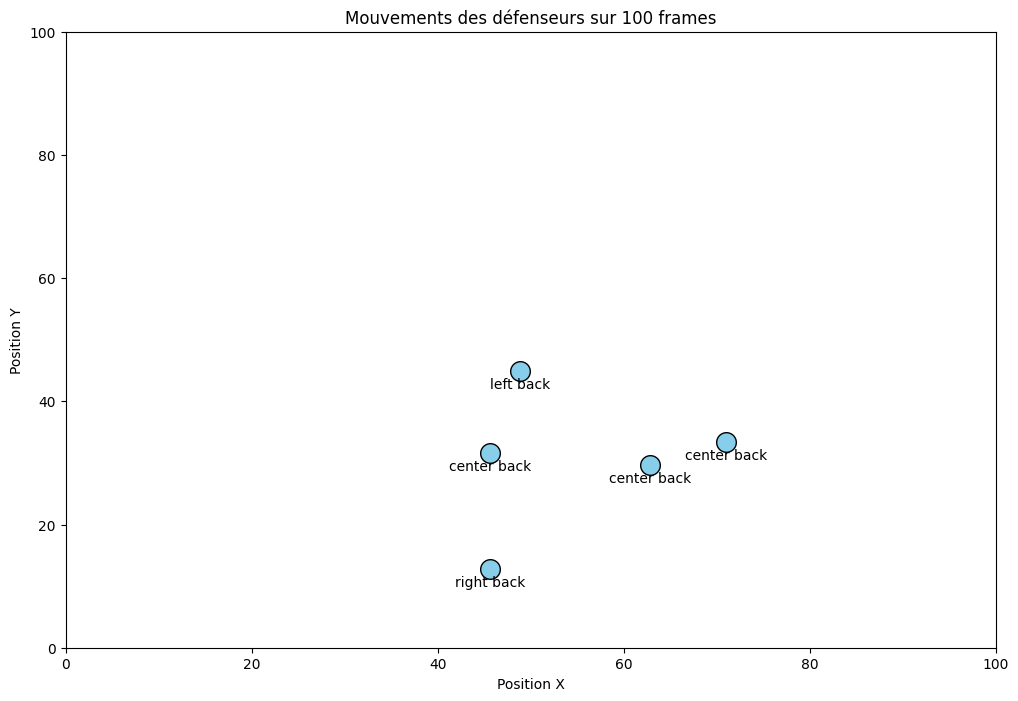

In [54]:
#Create a table with all matches
con.execute("""
    CREATE OR REPLACE TABLE tracking_games AS
SELECT
    *
FROM tracking_clean
WHERE session_type = 'game';
""")
df_match_players = con.execute(f"""
SELECT DISTINCT
    tg.player_pseudo,
    tg.sensor_id,
    s.position
FROM tracking_games tg
LEFT JOIN summary s
    ON tg.sensor_id = s.Sensor
   AND DATE(tg.session_date) = DATE(s.date)
WHERE DATE(tg.session_date) = '{match}'
ORDER BY tg.player_pseudo
""").df()

# Joueur et match
player_pseudo = df_match_players['player_pseudo'].iloc[0]

# Récupérer les données
df_player = con.execute(f"""
SELECT * 
FROM tracking_games
WHERE DATE(session_date) = '{match}'
  AND player_pseudo = '{player_pseudo}'
ORDER BY session_date
""").df()

# Échantillonner si tu veux moins de points
df_player_sampled = df_player.iloc[::10, :]

# Récupérer les défenseurs
defender_positions = df_match_players[df_match_players['position'].str.contains(position, case=False, na=False)]

# Choisir le temps que tu veux afficher (ex: 50ème frame)
n_frames = duration

# Récupérer les données de tous les défenseurs
players_data = {}
for _, row in defender_positions.iterrows():
    player_pseudo = row['player_pseudo']
    player_position = row['position']
    
    df_player = con.execute(f"""
        SELECT * 
        FROM tracking_games
        WHERE DATE(session_date) = '{match}'
          AND player_pseudo = '{player_pseudo}'
        ORDER BY session_date
    """).df()
    
    # Limiter à n_frames si le joueur a plus de points
    df_player = df_player.iloc[:n_frames]
    
    if len(df_player) == 0:
        continue
    
    players_data[player_pseudo] = {
        'position': player_position,
        'x': df_player['x_pos'].values,
        'y': df_player['y_pos'].values
    }

# Créer la figure
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlim(0, 100)  # Ajuster selon dimensions terrain
ax.set_ylim(0, 100)
ax.set_xlabel('Position X')
ax.set_ylabel('Position Y')
ax.set_title(f'Mouvements des défenseurs sur {n_frames} frames')

# Initialiser les cercles et textes
circles = {}
texts = {}
for player, data in players_data.items():
    circle = ax.scatter(data['x'][0], data['y'][0], s=200, edgecolor='black', facecolor='skyblue', zorder=3)
    text = ax.text(data['x'][0], data['y'][0]-1, data['position'], ha='center', va='top', fontsize=10, zorder=4)
    circles[player] = circle
    texts[player] = text

# Fonction d'update pour l'animation
def update(frame):
    for player, data in players_data.items():
        if frame < len(data['x']):
            circles[player].set_offsets([data['x'][frame], data['y'][frame]])
            texts[player].set_position((data['x'][frame], data['y'][frame]-1))
    return list(circles.values()) + list(texts.values())

# Créer l'animation
ani = FuncAnimation(fig, update, frames=n_frames, interval=100, blit=True)
ani.save(f"{match}__{position}_deplacement.mp4", writer=FFMpegWriter(fps=10, metadata=dict(artist='Me'), bitrate=1800))
print(f"Animation enregistrée : {match}_{position}_deplacement.mp4")



In [55]:
# ============================================================================ 
# METRICS CALCULATION POUR UN MATCH SPÉCIFIQUE
# ============================================================================

# Récupérer tous les joueurs pour ce match
df_match = con.execute(f"""
SELECT
    t.player_pseudo,
    t.sensor_id,
    s.position,
    t.session_date
FROM tracking_games t
INNER JOIN summary s
    ON t.sensor_id = s.Sensor
    AND DATE(s.date) = t.session_date
WHERE t.session_date = '{match}'
AND t.session_type = '{session_type}'
GROUP BY t.player_pseudo, t.sensor_id, s.position, t.session_date
ORDER BY t.player_pseudo
""").df()

if df_match.empty:
    raise ValueError(f"Aucun match trouvé pour la date {match}")

# ===============================
# Calculer metrics pour chaque joueur
# ===============================
metrics_rows = []

for player in df_match['player_pseudo'].unique():
    
    # Récupérer les données de tracking du joueur pour ce match
    df_player = con.execute(f"""
        SELECT *
        FROM tracking_games
        WHERE session_date = '{match}'
        AND session_type = '{session_type}'
        AND player_pseudo = '{player}'
    """).df()
    
    if df_player.empty:
        print(f"Aucune donnée pour le joueur {player} sur ce match")
        continue

    # Calculer les metrics
    metrics = compute_metrics(df_player)
    metrics['player_pseudo'] = player
    metrics['session_date'] = match
    metrics_rows.append(metrics)

# ===============================
# Convertir en DataFrame et créer la table
# ===============================
df_metrics = pd.DataFrame(metrics_rows)
table_name_game = f"{session_type}_metrics_{match.replace('-', '_')}"
con.execute(f"CREATE OR REPLACE TABLE {table_name_game} AS SELECT * FROM df_metrics")
print(f"Table '{table_name_game}' créée/replacée avec succès pour le match {match} !")


Table 'game_metrics_2020_02_01' créée/replacée avec succès pour le match 2020-02-01 !


In [56]:
#Calculer les distances totales parcourues par chaque joueur pendant le match

def distance(match, top=5):
    distances = {}

    for _, row in df_match_players.iterrows():
        player_pseudo = row['player_pseudo']

        df_player = con.execute(f"""
            SELECT * 
            FROM tracking_games
            WHERE DATE(session_date) = '{match}'
              AND player_pseudo = '{player_pseudo}'
            ORDER BY session_date
        """).df()

        if len(df_player) < 2:
            distances[player_pseudo] = 0.0
            continue

        dx = df_player['x_pos'].diff().fillna(0)
        dy = df_player['y_pos'].diff().fillna(0)
        total_distance = np.sqrt(dx**2 + dy**2).sum()

        distances[player_pseudo] = total_distance

    return sorted(distances.items(), key=lambda x: x[1], reverse=True)[:top]

def vitesse_max(match, top=5):
    vitesses = {}

    for _, row in df_match_players.iterrows():
        player_pseudo = row['player_pseudo']

        df_player = con.execute(f"""
            SELECT * 
            FROM tracking_games
            WHERE DATE(session_date) = '{match}'
              AND player_pseudo = '{player_pseudo}'
            ORDER BY session_date
        """).df()

        if len(df_player) < 2:
            vitesses[player_pseudo] = 0.0
            continue

        vitesses[player_pseudo] = df_player['speed_kmh'].max()

    return sorted(vitesses.items(), key=lambda x: x[1], reverse=True)[:top]

def acceleration_max(match, top=5):
    accelerations = {}
    dt = 0.1  # 10 Hz = 0.1 sec

    for _, row in df_match_players.iterrows():
        player_pseudo = row['player_pseudo']

        df_player = con.execute(f"""
            SELECT * 
            FROM tracking_games
            WHERE DATE(session_date) = '{match}'
              AND player_pseudo = '{player_pseudo}'
            ORDER BY session_date
        """).df()

        if len(df_player) < 2:
            accelerations[player_pseudo] = 0.0
            continue

        dx = df_player["x_pos"].diff().fillna(0)
        dy = df_player["y_pos"].diff().fillna(0)

        speeds = np.sqrt(dx**2 + dy**2) / dt
        accel = np.diff(speeds)

        accelerations[player_pseudo] = np.max(accel) if len(accel) > 0 else 0.0

    return sorted(accelerations.items(), key=lambda x: x[1], reverse=True)[:top]

In [57]:
# ===============================
# Récupération données du joueur
# ===============================
players_df = con.execute(f"""
    SELECT
        t.x_pos - 55 AS x_smooth,
        t.y_pos - 36 AS y_smooth,
        s.position
    FROM tracking_clean t
    JOIN summary s
        ON t.sensor_id = s.Sensor
    WHERE t.session_type = 'game'
      AND t.session_date = '{match}'
      AND t.player_pseudo = '{pseudo}'
""").df()

# Nettoyage des données manquantes
players_df = players_df.dropna(subset=['x_smooth', 'y_smooth', 'position'])

# Sampling pour réduire le nombre de points
if len(players_df) > sampling_rate:
    players_df = players_df.iloc[::sampling_rate]

print("Positions uniques :", players_df['position'].unique())

# ===============================
# Création catégorie simplifiée
# ===============================
players_df['group_position'] = np.select(
    [
        players_df['position'].str.contains('back', case=False),
        players_df['position'].str.contains('midfield', case=False),
        players_df['position'].str.contains('forward', case=False)
    ],
    [
        'Defense',
        'Midfield',
        'Attack'
    ],
    default='Other'
)

print("Groupes créés :", players_df['group_position'].unique())

# ===============================
# Fonction pour dessiner le terrain
# ===============================
def draw_pitch(ax):
    ax.set_facecolor('#1a472a')

    # Contours
    ax.plot([0, 0], [-34, 34], color='white')
    ax.plot([-52.5, 52.5], [-34, -34], color='white')
    ax.plot([-52.5, 52.5], [34, 34], color='white')
    ax.plot([-52.5, -52.5], [-34, 34], color='white')
    ax.plot([52.5, 52.5], [-34, 34], color='white')

    # Cercle central
    ax.add_patch(Circle((0,0), 9.15, edgecolor='white', facecolor='none'))
    ax.add_patch(Circle((0,0), 0.5, color='white'))

    # Limites
    ax.set_xlim(-55, 55)
    ax.set_ylim(-36, 36)
    ax.set_xticks([])
    ax.set_yticks([])

    return ax

# ===============================
# Création figure
# ===============================
plt.style.use("dark_background")
fig, ax = plt.subplots(figsize=(12, 8))

# Dessiner le terrain
draw_pitch(ax)

# Affichage du nombre de points
print("Points du joueur :", len(players_df))

# ===============================
# Heatmap du joueur
# ===============================
if len(players_df) > 10:
    sns.kdeplot(
        x=players_df['x_smooth'],
        y=players_df['y_smooth'],
        fill=True,
        cmap="inferno",
        bw_adjust=0.7,   # ajuste la douceur
        thresh=0.05,      # ignore les zones très faibles
        levels=30,        # nombre de niveaux de couleur
        alpha=0.9,
        ax=ax
    )

ax.set_title(f'Heatmap du joueur {pseudo} ({match})', fontsize=18)
plt.tight_layout()
heatmap_path = f"heatmap_{pseudo}_{match}.png"
plt.savefig(heatmap_path, dpi=300)
plt.close()

Positions uniques : <StringArray>
['center forward', 'ilip center', 'NA']
Length: 3, dtype: str
Groupes créés : <StringArray>
['Attack', 'Other']
Length: 2, dtype: str
Points du joueur : 110546


## PDF Match

In [58]:
def create_match_pdf(match, player_pseudo=None):
    """
    Crée un PDF de rapport de match avec :
    - Metrics pour tous les joueurs du match
    - Top 5 distances, vitesses et accélérations
    - Heatmap du match
    """
    pdf_path = f"Rapport_Match_{match}.pdf"
    doc = SimpleDocTemplate(pdf_path)
    elements = []

    styles = getSampleStyleSheet()
    title_style = styles["Heading1"]
    section_style = styles["Heading2"]
    normal_style = styles["Normal"]

    # =========================
    # HEADER
    # =========================
    elements.append(Paragraph("MATCH REPORT", title_style))
    elements.append(Spacer(1, 20))
    if player_pseudo:
        elements.append(Paragraph(f"<b>Joueur :</b> {player_pseudo}", normal_style))
    elements.append(Paragraph(f"<b>Date :</b> {match}", normal_style))
    elements.append(Spacer(1, 20))

    # =========================
    # METRICS POUR TOUS LES JOUEURS
    # =========================
    # Récupérer metrics pour tous les joueurs de ce match
    df_metrics = con.execute(f"""
        SELECT *
        FROM {session_type}_metrics_{match.replace('-', '_')}
    """).df()

    if df_metrics.empty:
        elements.append(Paragraph("Aucune donnée metrics disponible pour ce match.", normal_style))
    else:
        elements.append(Paragraph("METRICS - Tous les joueurs", section_style))
        elements.append(Spacer(1, 12))

        # Créer une table avec tous les joueurs et leurs metrics
        metrics_cols = df_metrics.columns.tolist()
        table_data = [metrics_cols] + df_metrics[metrics_cols].values.tolist()

        table = Table(table_data, repeatRows=1)
        table.setStyle(TableStyle([
            ('BACKGROUND', (0,0), (-1,0), colors.lightgrey),
            ('GRID', (0,0), (-1,-1), 0.5, colors.black),
            ('FONTSIZE', (0,0), (-1,-1), 8)
        ]))
        elements.append(table)
        elements.append(PageBreak())

    # =========================
    # TOP 5 DISTANCES, VITESSES, ACCÉLÉRATIONS
    # =========================
    elements.append(Paragraph("Top 5 Distances, Vitesses et Accélérations", section_style))
    elements.append(Spacer(1, 12))

    top_distance = distance(match, 5)
    top_speed = vitesse_max(match, 5)
    top_accel = acceleration_max(match, 5)

    elements.append(Paragraph("<b>Top 5 Distances :</b>", normal_style))
    for player, value in top_distance:
        elements.append(Paragraph(f"{player} : {value:.2f} m", normal_style))

    elements.append(Spacer(1, 10))
    elements.append(Paragraph("<b>Top 5 Vitesses max :</b>", normal_style))
    for player, value in top_speed:
        elements.append(Paragraph(f"{player} : {value:.2f} km/h", normal_style))

    elements.append(Spacer(1, 10))
    elements.append(Paragraph("<b>Top 5 Accélérations :</b>", normal_style))
    for player, value in top_accel:
        elements.append(Paragraph(f"{player} : {value:.2f} m/s²", normal_style))

    # =========================
    # PAGE BREAK HEATMAP
    # =========================
    elements.append(PageBreak())
    elements.append(Paragraph("HEATMAP", title_style))
    elements.append(Spacer(1, 20))

    # Assurez-vous que heatmap_path est défini avant
    img = Image(heatmap_path, width=6*inch, height=4*inch)
    elements.append(img)

    # =========================
    # BUILD PDF
    # =========================
    doc.build(elements)
    print(f"PDF généré : {pdf_path}")

# Exemple d'appel
create_match_pdf(match, player_pseudo=pseudo)


PDF généré : Rapport_Match_2020-02-01.pdf
